In [13]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [14]:
df=pd.read_csv('plant growth deep learning.csv')

In [15]:
# Step 2: Handle missing values
# First, let's see if there are any missing values
print(df.isnull().sum())

# We'll use SimpleImputer to fill missing values
# For numeric columns, we'll use the mean strategy
numeric_columns = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# For categorical columns (if any), we'll use the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])

# Step 3: Normalize numerical data
# We'll use MinMaxScaler to scale values between 0 and 1
scaler = MinMaxScaler()

# Exclude non-numeric columns from normalization
columns_to_normalize = ['SoilMoisture', 'SoilTemperature', 'AirTemperature', 
                        'Humidity', 'pH', 'WaterUsage', 'SolarRadiation', 'WindSpeed']

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Step 4: Handle categorical variables
# If CropType is categorical, we'll use one-hot encoding
if 'CropType' in categorical_columns:
    df = pd.get_dummies(df, columns=['CropType'], prefix='Crop')

# Step 5: Convert timestamp to datetime
df['ReadingTimestamp'] = pd.to_datetime(df['ReadingTimestamp'])

# Extract useful features from timestamp
df['Year'] = df['ReadingTimestamp'].dt.year
df['Month'] = df['ReadingTimestamp'].dt.month
df['Day'] = df['ReadingTimestamp'].dt.day
df['Hour'] = df['ReadingTimestamp'].dt.hour

# Step 6: Save the preprocessed data
df.to_csv('preprocessed_data.csv', index=False)

print("Data preprocessing completed. Preprocessed data saved to 'preprocessed_data.csv'")

FieldID               0
SoilMoisture          0
SoilTemperature       0
AirTemperature        0
Humidity              0
pH                    0
WaterUsage            0
CropType              0
IrrigationSystemID    0
ReadingTimestamp      0
SolarRadiation        0
WindSpeed             0
dtype: int64
Data preprocessing completed. Preprocessed data saved to 'preprocessed_data.csv'


In [16]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Load the preprocessed data
df = pd.read_csv('preprocessed_data.csv')

# Ensure ReadingTimestamp is datetime
df['ReadingTimestamp'] = pd.to_datetime(df['ReadingTimestamp'])

# 1. Calculate Growing Degree Days (GDD)
def calculate_gdd(row, base_temp=10):
    mean_temp = (row['AirTemperature'] + row['SoilTemperature']) / 2
    return max(0, mean_temp - base_temp)

df['GrowingDegreeDays'] = df.apply(calculate_gdd, axis=1)

# 2. Calculate Vapor Pressure Deficit (VPD)
def calculate_vpd(row):
    temp = row['AirTemperature']
    rh = row['Humidity']
    es = 0.6108 * np.exp(17.27 * temp / (temp + 237.3))
    ea = es * (rh / 100)
    return es - ea

df['VaporPressureDeficit'] = df.apply(calculate_vpd, axis=1)

# 3. Create time-based features
df['DayOfYear'] = df['ReadingTimestamp'].dt.dayofyear
df['WeekOfYear'] = df['ReadingTimestamp'].dt.isocalendar().week
df['IsWeekend'] = df['ReadingTimestamp'].dt.dayofweek.isin([5, 6]).astype(int)

# 4. Calculate rolling averages and standard deviations
window_sizes = [3, 7, 14]  # 3-day, 7-day, and 14-day windows
for window in window_sizes:
    df[f'SoilMoisture_RollingMean_{window}d'] = df.groupby('FieldID')['SoilMoisture'].rolling(window=window).mean().reset_index(0, drop=True)
    df[f'SoilMoisture_RollingStd_{window}d'] = df.groupby('FieldID')['SoilMoisture'].rolling(window=window).std().reset_index(0, drop=True)

# 5. Calculate cumulative values
df['CumulativeWaterUsage'] = df.groupby('FieldID')['WaterUsage'].cumsum()
df['CumulativeGDD'] = df.groupby('FieldID')['GrowingDegreeDays'].cumsum()

# 6. Create interaction features
df['MoistureTemperatureInteraction'] = df['SoilMoisture'] * df['SoilTemperature']
df['pHMoistureInteraction'] = df['pH'] * df['SoilMoisture']

# 7. Calculate rate of change for key variables
df['SoilMoistureChange'] = df.groupby('FieldID')['SoilMoisture'].diff()
df['SoilTemperatureChange'] = df.groupby('FieldID')['SoilTemperature'].diff()

# 8. Create binary features for extreme conditions
df['IsHotDay'] = (df['AirTemperature'] > df['AirTemperature'].quantile(0.95)).astype(int)
df['IsWetSoil'] = (df['SoilMoisture'] > df['SoilMoisture'].quantile(0.95)).astype(int)

# 9. Calculate statistical moments for key variables
for col in ['SoilMoisture', 'SoilTemperature', 'AirTemperature']:
    df[f'{col}_Skew'] = df.groupby('FieldID')[col].transform(lambda x: skew(x))
    df[f'{col}_Kurtosis'] = df.groupby('FieldID')[col].transform(lambda x: kurtosis(x))

# Save the feature-engineered data
df.to_csv('feature_engineered_data.csv', index=False)

print("Feature engineering completed. Data saved to 'feature_engineered_data.csv'")

Feature engineering completed. Data saved to 'feature_engineered_data.csv'


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_csv('feature_engineered_data.csv')

# Print column names to verify
print("Columns in the DataFrame:")
print(df.columns)

# Define columns to drop
columns_to_drop = ['ReadingTimestamp', 'FieldID', 'IrrigationSystemID']

# Add 'CropType' to columns_to_drop if it exists
if 'CropType' in df.columns:
    columns_to_drop.append('CropType')

# Drop columns
X = df.drop(columns_to_drop, axis=1, errors='ignore')
y = df['SoilMoisture']  # Assuming we're predicting soil moisture

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, 
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# Evaluate model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Dense Neural Network Results:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

Columns in the DataFrame:
Index(['FieldID', 'SoilMoisture', 'SoilTemperature', 'AirTemperature',
       'Humidity', 'pH', 'WaterUsage', 'IrrigationSystemID',
       'ReadingTimestamp', 'SolarRadiation', 'WindSpeed', 'Crop_Corn',
       'Crop_Other', 'Crop_Soybean', 'Crop_Wheat', 'Year', 'Month', 'Day',
       'Hour', 'GrowingDegreeDays', 'VaporPressureDeficit', 'DayOfYear',
       'WeekOfYear', 'IsWeekend', 'SoilMoisture_RollingMean_3d',
       'SoilMoisture_RollingStd_3d', 'SoilMoisture_RollingMean_7d',
       'SoilMoisture_RollingStd_7d', 'SoilMoisture_RollingMean_14d',
       'SoilMoisture_RollingStd_14d', 'CumulativeWaterUsage', 'CumulativeGDD',
       'MoistureTemperatureInteraction', 'pHMoistureInteraction',
       'SoilMoistureChange', 'SoilTemperatureChange', 'IsHotDay', 'IsWetSoil',
       'SoilMoisture_Skew', 'SoilMoisture_Kurtosis', 'SoilTemperature_Skew',
       'SoilTemperature_Kurtosis', 'AirTemperature_Skew',
       'AirTemperature_Kurtosis'],
      dtype='object')


C:\Users\behur\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\behur\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\behur\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\behur\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2981 - val_loss: 0.1853
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1651 - val_loss: 0.1160
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1111 - val_loss: 0.0904
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0920 - val_loss: 0.0833
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0865 - val_loss: 0.0818
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0829 - val_loss: 0.0816
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0855 - val_loss: 0.0815
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0838 - val_loss: 0.0815
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0851 - val_loss: 0.0815
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0836 - val_loss: 0.0815
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0849 - val_loss: 0.0815
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━

C:\Users\behur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - custom_accuracy: 3.5722e-04 - loss: 2045.5873 - mae: 40.2696 - val_custom_accuracy: 0.0037 - val_loss: 1480.3328 - val_mae: 32.9238
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - custom_accuracy: 0.0024 - loss: 1356.5258 - mae: 31.0435 - val_custom_accuracy: 0.0025 - val_loss: 1136.0182 - val_mae: 28.0367
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - custom_accuracy: 0.0037 - loss: 1043.9666 - mae: 26.5652 - val_custom_accuracy: 0.0046 - val_loss: 887.7778 - val_mae: 24.4484
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - custom_accuracy: 0.0024 - loss: 814.3000 - mae: 23.3291 - val_custom_accuracy: 0.0019 - val_loss: 712.2776 - val_mae: 21.9357
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - custom_accuracy: 0.0039 - loss: 659.4968 - mae: 21.0421 - val_custom_accuracy: 0.0012 - val_loss: 591.7579 - val_mae: 20.1609
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - custom_accuracy: 0.0039 

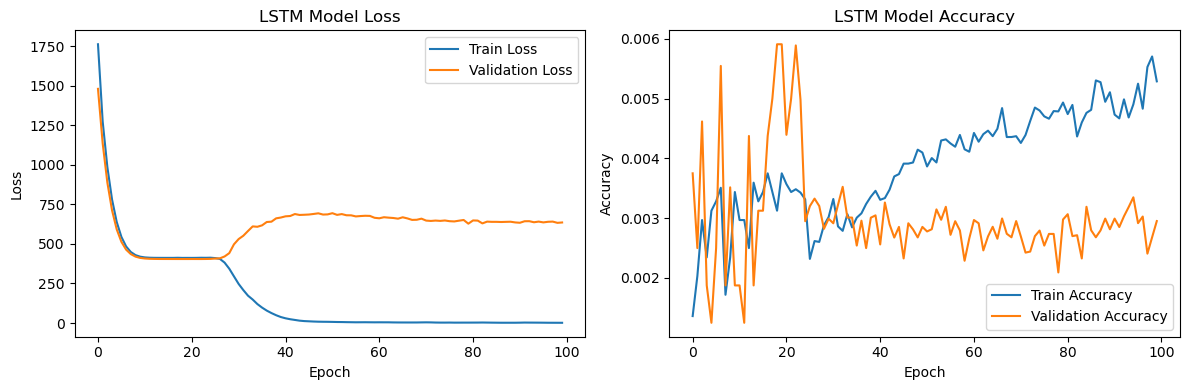

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Convert timestamp to datetime
    df['ReadingTimestamp'] = pd.to_datetime(df['ReadingTimestamp'])
    
    # Create time-based features
    df['Hour'] = df['ReadingTimestamp'].dt.hour
    df['DayOfWeek'] = df['ReadingTimestamp'].dt.dayofweek
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['CropType', 'IrrigationSystemID'])
    
    # Select features and target
    features = df.drop(['FieldID', 'ReadingTimestamp', 'SoilMoisture'], axis=1)
    target = df['SoilMoisture']
    
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, target

# Prepare data for RNN (reshape to 3D)
def prepare_rnn_data(X, y, time_steps):
    X_rnn, y_rnn = [], []
    for i in range(len(X) - time_steps):
        X_rnn.append(X[i:i+time_steps])
        y_rnn.append(y[i+time_steps])
    return np.array(X_rnn), np.array(y_rnn)

# Custom accuracy metric
def custom_accuracy(y_true, y_pred, tolerance=0.1):
    return K.mean(K.abs(y_true - y_pred) <= tolerance)

# Build and train LSTM model
def build_and_train_rnn(X_train, y_train, X_val, y_val):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae', custom_accuracy])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)
    return model, history

# Main execution
file_path = 'plant growth deep learning.csv'  # Your dataset name
X, y = load_and_preprocess_data(file_path)

# Convert X and y to DataFrame/Series before splitting
X = pd.DataFrame(X)
y = pd.Series(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reset index to avoid index misalignment issues
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

# Prepare data for RNN
time_steps = 10  # Adjust as needed
X_train_rnn, y_train_rnn = prepare_rnn_data(X_train, y_train, time_steps)
X_val_rnn, y_val_rnn = prepare_rnn_data(X_val, y_val, time_steps)
X_test_rnn, y_test_rnn = prepare_rnn_data(X_test, y_test, time_steps)

# Train LSTM model
rnn_model, rnn_history = build_and_train_rnn(X_train_rnn, y_train_rnn, X_val_rnn, y_val_rnn)

# Evaluate LSTM model
rnn_mse, rnn_mae, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test_rnn)
print(f"LSTM - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}, Accuracy: {rnn_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['custom_accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\behur\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - custom_accuracy: 0.0018 - loss: 1803.4707 - mae: 36.8764 - val_custom_accuracy: 0.0019 - val_loss: 953.0537 - val_mae: 25.3929
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - custom_accuracy: 0.0015 - loss: 816.3392 - mae: 23.3363 - val_custom_accuracy: 0.0037 - val_loss: 595.9742 - val_mae: 20.2221
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - custom_accuracy: 0.0018 - loss: 567.4924 - mae: 19.9995 - val_custom_accuracy: 0.0037 - val_loss: 460.9884 - val_mae: 18.1744
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - custom_accuracy: 0.0038 - loss: 445.0169 - mae: 18.0673 - val_custom_accuracy: 0.0037 - val_loss: 418.2056 - val_mae: 17.5147
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - custom_accuracy: 0.0038 - loss: 417.0739 - mae: 17.6214 - val_custom_accuracy: 0.0025 - val_loss: 407.4162 - val_mae: 17.3476
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - custom_accuracy: 0.0033 - loss: 

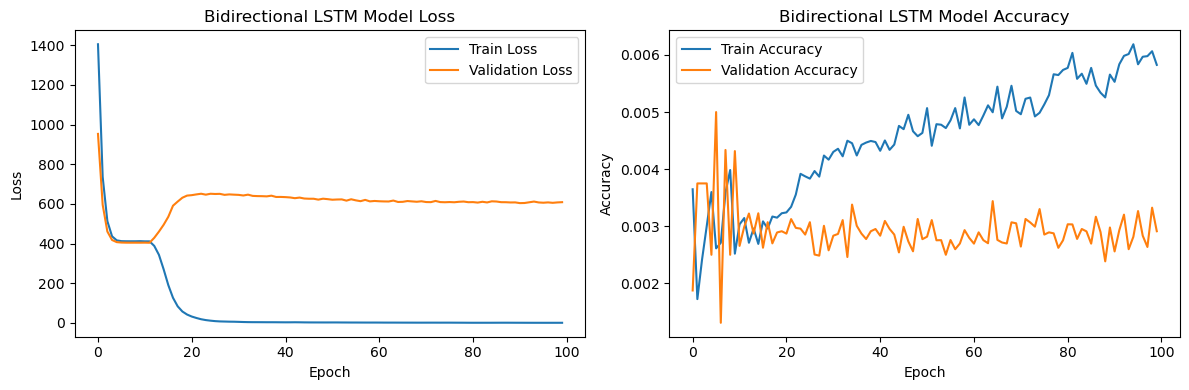

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Convert timestamp to datetime
    df['ReadingTimestamp'] = pd.to_datetime(df['ReadingTimestamp'])
    
    # Create time-based features
    df['Hour'] = df['ReadingTimestamp'].dt.hour
    df['DayOfWeek'] = df['ReadingTimestamp'].dt.dayofweek
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['CropType', 'IrrigationSystemID'])
    
    # Select features and target
    features = df.drop(['FieldID', 'ReadingTimestamp', 'SoilMoisture'], axis=1)
    target = df['SoilMoisture']
    
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, target

# Prepare data for RNN (reshape to 3D)
def prepare_rnn_data(X, y, time_steps):
    X_rnn, y_rnn = [], []
    for i in range(len(X) - time_steps):
        X_rnn.append(X[i:i+time_steps])
        y_rnn.append(y[i+time_steps])
    return np.array(X_rnn), np.array(y_rnn)

# Custom accuracy metric
def custom_accuracy(y_true, y_pred, tolerance=0.1):
    return K.mean(K.abs(y_true - y_pred) <= tolerance)

# Build and train Bidirectional LSTM model
def build_and_train_rnn(X_train, y_train, X_val, y_val):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Bidirectional(LSTM(32)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae', custom_accuracy])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)
    return model, history

# Main execution
file_path = 'plant growth deep learning.csv'  # Your dataset name
X, y = load_and_preprocess_data(file_path)

# Convert X and y to DataFrame/Series before splitting
X = pd.DataFrame(X)
y = pd.Series(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reset index to avoid index misalignment issues
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

# Prepare data for RNN
time_steps = 10  # Adjust as needed
X_train_rnn, y_train_rnn = prepare_rnn_data(X_train, y_train, time_steps)
X_val_rnn, y_val_rnn = prepare_rnn_data(X_val, y_val, time_steps)
X_test_rnn, y_test_rnn = prepare_rnn_data(X_test, y_test, time_steps)

# Train Bidirectional LSTM model
rnn_model, rnn_history = build_and_train_rnn(X_train_rnn, y_train_rnn, X_val_rnn, y_val_rnn)

# Evaluate Bidirectional LSTM model
rnn_mse, rnn_mae, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test_rnn)
print(f"Bidirectional LSTM - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}, Accuracy: {rnn_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['custom_accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100


C:\Users\behur\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - custom_accuracy: 0.0018 - loss: 1275.0170 - mae: 28.9369 - val_custom_accuracy: 0.0081 - val_loss: 124.4616 - val_mae: 8.7224
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - custom_accuracy: 0.0076 - loss: 84.0045 - mae: 7.2469 - val_custom_accuracy: 0.0050 - val_loss: 81.2695 - val_mae: 7.1292
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - custom_accuracy: 0.0148 - loss: 56.9930 - mae: 5.9878 - val_custom_accuracy: 0.0131 - val_loss: 69.8213 - val_mae: 6.5821
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - custom_accuracy: 0.0141 - loss: 47.2244 - mae: 5.4205 - val_custom_accuracy: 0.0069 - val_loss: 61.9891 - val_mae: 6.1984
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - custom_accuracy: 0.0084 - loss: 39.8508 - mae: 5.0178 - val_custom_accuracy: 0.0044 - val_loss: 55.7502 - val_mae: 5.9034
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - custom_accuracy: 0.0156 - loss: 34.2875 - mae: 4.6184 - val_custom_a

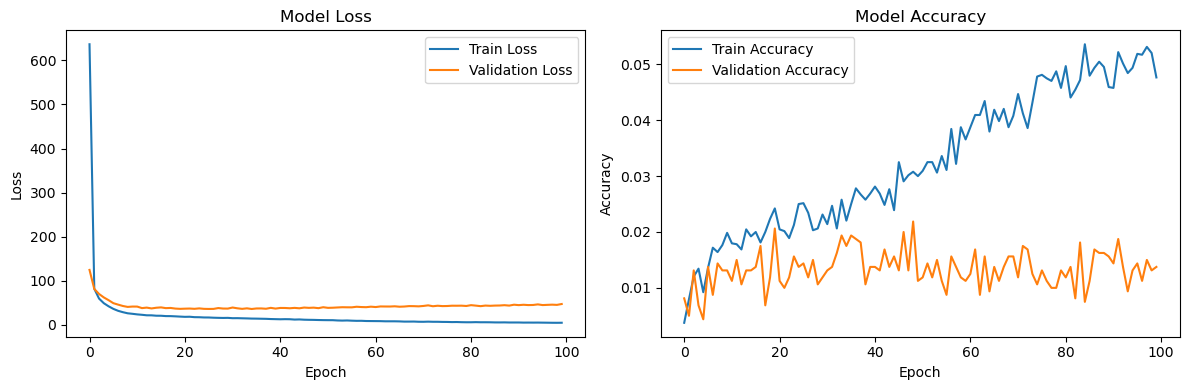

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Convert timestamp to datetime
    df['ReadingTimestamp'] = pd.to_datetime(df['ReadingTimestamp'])
    
    # Create time-based features
    df['Hour'] = df['ReadingTimestamp'].dt.hour
    df['DayOfWeek'] = df['ReadingTimestamp'].dt.dayofweek
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['CropType', 'IrrigationSystemID'])
    
    # Select features and target
    features = df.drop(['FieldID', 'ReadingTimestamp', 'SoilMoisture'], axis=1)
    target = df['SoilMoisture']
    
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, target

# Custom accuracy metric
def custom_accuracy(y_true, y_pred, tolerance=0.1):
    return K.mean(K.abs(y_true - y_pred) <= tolerance)

# Build and train ANN model
def build_and_train_ann(X_train, y_train, X_val, y_val):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae', custom_accuracy])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)
    return model, history

# Main execution
file_path = 'plant growth deep learning.csv'  # Your specific dataset name
X, y = load_and_preprocess_data(file_path)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train ANN model
ann_model, ann_history = build_and_train_ann(X_train, y_train, X_val, y_val)

# Evaluate ANN model
ann_mse, ann_mae, ann_accuracy = ann_model.evaluate(X_test, y_test)
print(f"ANN - MSE: {ann_mse:.4f}, MAE: {ann_mae:.4f}, Accuracy: {ann_accuracy:.4f}")

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['loss'], label='Train Loss')
plt.plot(ann_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ann_history.history['custom_accuracy'], label='Train Accuracy')
plt.plot(ann_history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\behur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - custom_accuracy: 5.9946e-04 - loss: 2013.3519 - mae: 39.6664 - val_custom_accuracy: 0.0031 - val_loss: 1363.7194 - val_mae: 31.2889
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - custom_accuracy: 0.0027 - loss: 1258.1486 - mae: 29.6353 - val_custom_accuracy: 0.0012 - val_loss: 1024.3290 - val_mae: 26.4160
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - custom_accuracy: 0.0039 - loss: 957.1160 - mae: 25.4095 - val_custom_accuracy: 0.0044 - val_loss: 791.9843 - val_mae: 23.0760
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - custom_accuracy: 0.0033 - loss: 727.5623 - mae: 22.0884 - val_custom_accuracy: 0.0031 - val_loss: 635.1631 - val_mae: 20.8006
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - custom_accuracy: 0.0032 - loss: 607.3626 - mae: 20.5338 - val_custom_accuracy: 0.0025 - val_loss: 534.5541 - val_mae: 19.3113
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - custom_accuracy: 0.0034 -

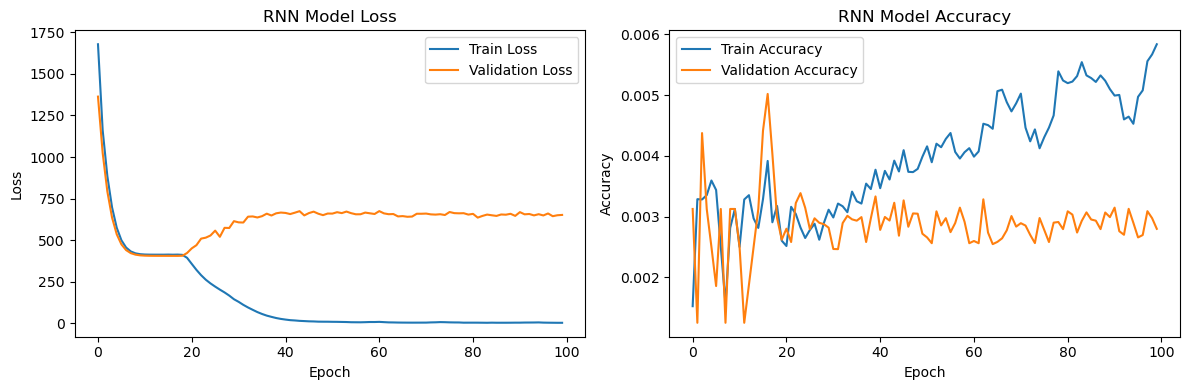

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Convert timestamp to datetime
    df['ReadingTimestamp'] = pd.to_datetime(df['ReadingTimestamp'])
    
    # Create time-based features
    df['Hour'] = df['ReadingTimestamp'].dt.hour
    df['DayOfWeek'] = df['ReadingTimestamp'].dt.dayofweek
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['CropType', 'IrrigationSystemID'])
    
    # Select features and target
    features = df.drop(['FieldID', 'ReadingTimestamp', 'SoilMoisture'], axis=1)
    target = df['SoilMoisture']
    
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, target

# Prepare data for RNN (reshape to 3D)
def prepare_rnn_data(X, y, time_steps):
    X_rnn, y_rnn = [], []
    for i in range(len(X) - time_steps):
        X_rnn.append(X[i:i+time_steps])
        y_rnn.append(y[i+time_steps])
    return np.array(X_rnn), np.array(y_rnn)

# Custom accuracy metric
def custom_accuracy(y_true, y_pred, tolerance=0.1):
    return K.mean(K.abs(y_true - y_pred) <= tolerance)

# Build and train RNN model
def build_and_train_rnn(X_train, y_train, X_val, y_val):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae', custom_accuracy])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)
    return model, history

# Main execution
file_path = 'plant growth deep learning.csv'  # Your dataset name
X, y = load_and_preprocess_data(file_path)

# Convert X and y to DataFrame/Series before splitting
X = pd.DataFrame(X)
y = pd.Series(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reset index to avoid index misalignment issues
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

# Prepare data for RNN
time_steps = 10  # Adjust as needed
X_train_rnn, y_train_rnn = prepare_rnn_data(X_train, y_train, time_steps)
X_val_rnn, y_val_rnn = prepare_rnn_data(X_val, y_val, time_steps)
X_test_rnn, y_test_rnn = prepare_rnn_data(X_test, y_test, time_steps)

# Train RNN model
rnn_model, rnn_history = build_and_train_rnn(X_train_rnn, y_train_rnn, X_val_rnn, y_val_rnn)

# Evaluate RNN model
rnn_mse, rnn_mae, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test_rnn)
print(f"RNN - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}, Accuracy: {rnn_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['custom_accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
